# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

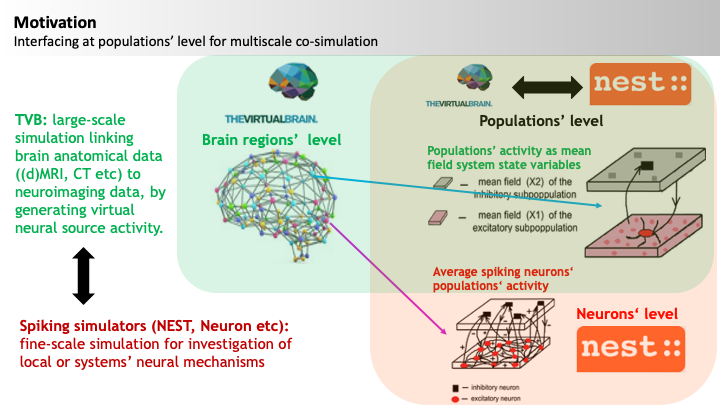

In [1]:
from IPython.display import Image, display
display(Image(filename='pics/ConceptGraph1.png',  width=1000, unconfined=False))

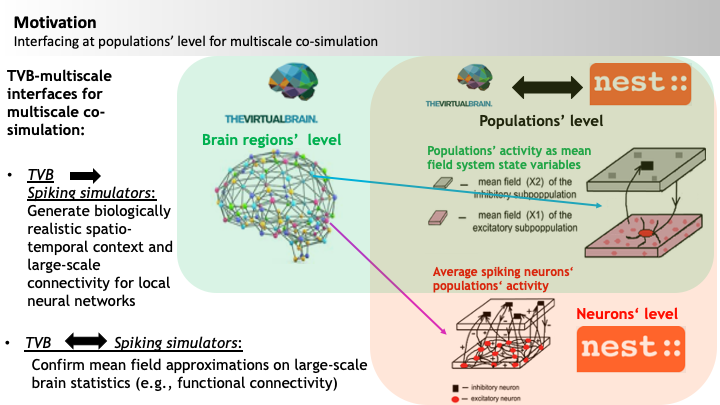

In [2]:
display(Image(filename='pics/ConceptGraph2.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

# TVB - NEST co-simulation 

## Wilson - Cowan TVB mean field model

For every region node $n\prime$ modelled as a mean-field node in TVB:

Population activity dynamics (1 excitatory and 1 inhibitory population):

 $\dot{E}_k = \dfrac{1}{\tau_e} (-E_k  + (k_e - r_e E_k) \mathcal{S}_e (\alpha_e \left( c_{ee} E_k - c_{ei} I_k  + P_k - \theta_e + \mathbf{\Gamma}(E_k, E_j, u_{kj}) + W_{\zeta}\cdot E_j + W_{\zeta}\cdot I_j\right) )) $
 
$
            \dot{I}_k = \dfrac{1}{\tau_i} (-I_k  + (k_i - r_i I_k) \mathcal{S}_i (\alpha_i \left( c_{ie} E_k - c_{ee} I_k  + Q_k - \theta_i + \mathbf{\Gamma}(E_k, E_j, u_{kj}) + W_{\zeta}\cdot E_j + W_{\zeta}\cdot I_j\right) ))$


## Spiking network model in NEST

using "iaf_cond_alpha" spiking neuronal model.

## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ w_{TVB->NEST} * E(t) $, 

Inhomogeneous spike generator NEST devices are used as TVB "proxy" nodes and generate independent Poisson-random spike trains 

$ \left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $

Alternatively, the spike trains are generated outside NEST using the Elephant software and inserted to NEST via spike generator devices.



## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instantaneous population mean rate that overrides

$ {E_{_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in E_n}}{N_E * dt} $ 

$ {I_{_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in I_n}}{N_I * dt} $

in  spikes/sec.

This update process concerns only the TVB region nodes that are simulated exclusively in NEST, as spiking networks. All the rest of TVB nodes will follow the equations of the mean field model described above.


## Simulator loop

### Simulating several (i.e., minimally 2) NEST time steps for every 1 TVB time step for stable integration

### Synchronizaion every minimum delay time between the two simulators.

# WORKFLOW:

In [3]:

from tvb_multiscale.tvb_nest.config import Config
from examples.parallel.wilson_cowan.config import configure

config = configure(config_class=Config)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

2023-05-11 14:58:27,327 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2023-05-11 14:58:27,327 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2023-05-11 14:58:27,332 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2023-05-11 14:58:27,332 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2023-05-11 14:58:27,337 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2023-05-11 14:58:27,337 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2023-05-11 14:58:27,342 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2023-05-11 14:58:27,342 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2023-05-11 14:58:27,348 - INFO - tvb_multiscale.tv

## BACKEND: 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

In [4]:
# This would run on TVB only before creating any multiscale cosimulation interface connections.
from examples.parallel.tvb_nest.wilson_cowan.tvb_config import build_tvb_simulator

simulator = build_tvb_simulator(config=config, config_class=Config)


2023-05-11 14:58:29,374 - ERROR - tvb_multiscale.core.tvb.cosimulator.cosimulator_parallel - Bad Simulator.integrator.noise.nsig shape: (2, 1, 1)
CoSimulatorParallel (
  title ........................... 'CoSimulatorParallel gid: d09bd8ca-0ec1-4752-b17f-cf0752c6e25b'
  Type ............................ 'CoSimulatorParallel'
  model ........................... WilsonCowan gid: d8a5367d-f6b3-4a2c-86da-8627f529684c
  output_interfaces ............... None
  input_interfaces ................ None
  out_proxy_inds .................. --------------------
  shape ........................... (0,)
  dtype ........................... int64
  is empty ........................ True
  exclusive ....................... False
  voi ............................. --------------------
  proxy_inds ...................... --------------------
  synchronization_time ............ 0.0
  connectivity .................... Connectivity gid: 92654179-6089-4221-84cb-87f2c6225075
  conduction_speed ...............

## BACKEND: 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [5]:
# This would run on NEST only before creating any multiscale cosimulation interface connections.
# Here it is assumed that the TVB simulator is already created and we can get some of its attributes, 
# either by directly accessing it, or via serialization.

from examples.parallel.tvb_nest.wilson_cowan.nest_config import build_nest_network


nest_network, nest_nodes_inds = build_nest_network(config=config, config_class=Config)



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: HEAD@c545255f7
 Built: Nov 15 2022 13:46:10

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

Building NESTNetwork...
2023-05-11 14:58:29,761 - INFO - tvb_multiscale.core.spiking_models.network - <class 'tvb_multiscale.tvb_nest.nest_models.network.NESTNetwork'> created!
2023-05-11 14:58:29,761 - INFO - tvb_multiscale.core.spiking_models.network - <class 'tvb_multiscale.tvb_nest.nest_models.network.NESTNetwork'> created!

...created: OrderedDict([('title', "'NESTPopulation gid: bef11d92-b979-4fa2-817e-0207b3901a93'"), ('Type', "'NESTPopulation'"), ('_nodes', 'NodeCollection(metadata=None, model=iaf_cond_alpha, size=10, first=1, last=10)'), ('label', "'E'"), ('model', "'NESTPopulation'"), ('brain_region', "'bankssts_L'"), ('gid', "UUID('bef11d92-b

## FRONTEND: 3. Build the TVB-NEST interface

In [6]:

# options for a nonopinionated builder:
from tvb_multiscale.core.interfaces.base.transformers.models.models import Transformers
from tvb_multiscale.core.interfaces.base.transformers.builders import \
        DefaultTVBtoSpikeNetTransformers, DefaultSpikeNetToTVBTransformers, \
        DefaultTVBtoSpikeNetModels, DefaultSpikeNetToTVBModels
from tvb_multiscale.tvb_nest.interfaces.builders import \
        TVBtoNESTModels, NESTInputProxyModels, DefaultTVBtoNESTModels, \
        NESTtoTVBModels, NESTOutputProxyModels, DefaultNESTtoTVBModels

    
    
def print_enum(enum):
    print("\n", enum)
    for name, member in enum.__members__.items():
        print(name,"= ", member.value)
    
    
print("Available input (NEST->TVB update) / output (TVB->NEST coupling) interface models:")
print_enum(TVBtoNESTModels)
print_enum(NESTtoTVBModels)
    
    
print("\n\nAvailable input (spikeNet->TVB update) / output (TVB->spikeNet coupling) transformer models:")

print_enum(DefaultTVBtoSpikeNetModels)
print_enum(DefaultTVBtoSpikeNetTransformers)
    
print_enum(DefaultSpikeNetToTVBModels)
print_enum(DefaultSpikeNetToTVBTransformers)    
    
    
print("\n\nAvailable input (NEST->TVB update) / output (TVB->NEST coupling) proxy models:")

print_enum(DefaultTVBtoNESTModels)
print_enum(NESTInputProxyModels)
    
print_enum(NESTOutputProxyModels)
print_enum(DefaultNESTtoTVBModels)
    
print("\n\nAll basic transformer models:")
print_enum(Transformers)
    


Available input (NEST->TVB update) / output (TVB->NEST coupling) interface models:

 <enum 'TVBtoSpikeNetModels'>
RATE =  0
SPIKES =  1
CURRENT =  2

 <enum 'SpikeNetToTVBModels'>
SPIKES =  0
VOLTAGE =  1


Available input (spikeNet->TVB update) / output (TVB->spikeNet coupling) transformer models:

 <enum 'DefaultTVBtoSpikeNetModels'>
RATE =  RATE
SPIKES =  SPIKES_SINGLE_INTERACTION
CURRENT =  CURRENT

 <enum 'DefaultTVBtoSpikeNetTransformers'>
RATE =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.base.LinearRate'>
SPIKES =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.elephant.RatesToSpikesElephantPoisson'>
SPIKES_SINGLE_INTERACTION =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.elephant.RatesToSpikesElephantPoissonSingleInteraction'>
SPIKES_MULTIPLE_INTERACTION =  <class 'tvb_multiscale.core.interfaces.base.transformers.models.elephant.RatesToSpikesElephantPoissonMultipleInteraction'>
CURRENT =  <class 'tvb_multiscale.core.int

In [7]:
from examples.parallel.tvb_nest.wilson_cowan.tvb_interface_config import configure_TVB_remote_interfaces
from examples.parallel.tvb_nest.wilson_cowan.nest_interface_config import configure_NEST_remote_interfaces
from examples.parallel.tvb_nest.wilson_cowan.transformers_config import \
    configure_TVBtoNEST_remote_transformer_interfaces, configure_NESTtoTVB_remote_transformer_interfaces

tvb_interface_builder = configure_TVB_remote_interfaces(simulator=simulator, config=config, config_class=Config)

nest_interface_builder = configure_NEST_remote_interfaces(config=config, config_class=Config)

tvb_to_nest_interface_builder = configure_TVBtoNEST_remote_transformer_interfaces(config=config, config_class=Config)

nest_to_tvb_interface_builder = configure_NESTtoTVB_remote_transformer_interfaces(config=config, config_class=Config)




output (TVB-> coupling) interfaces' configurations:


input (TVB<- update) interfaces' configurations:


output (spikeNet -> coupling) interfaces' configurations:


input (spikeNet <- update) interfaces' configurations:


output (->Transformer-> coupling) interfaces' configurations:



AttributeError: 'TVBtoSpikeNetTransformerBuilder' object has no attribute 'dump_all_interfaces'

## BACKEND

In [ ]:
def build_TVB_interfaces(simulator, tvb_interface_builder=None):
    
    if tvb_interface_builder is None:
        tvb_interface_builder = prepare_TVB_interface(simulator=simulator)[0]
    else:
        tvb_interface_builder.tvb_cosimulator = simulator
    
    # Load TVB interfaces configurations
    tvb_interface_builder.load_all_interfaces()
    
    # Configure TVB interfaces' builder:
    tvb_interface_builder.configure()
    # tvb_interface_builder.print_summary_info_details(recursive=1)
    
    # Build interfaces and attach them to TVB simulator
    simulator = tvb_interface_builder.build()
    
    # simulator.print_summary_info(recursive=3)
    # simulator.print_summary_info_details(recursive=3)

    print("\n\noutput (TVB-> coupling) interfaces:\n")
    simulator.output_interfaces.print_summary_info_details(recursive=2)
    
    print("\n\ninput (TVB<- update) interfaces:\n")
    simulator.input_interfaces.print_summary_info_details(recursive=2)
    
    return simulator


def build_TVBtoSpikeNet_transformer_interfaces(tvb_to_spikeNet_trans_interface_builder=None):
    
    if tvb_to_spikeNet_trans_interface_builder is None:
        tvb_to_spikeNet_trans_interface_builder = prepare_TVBtoSpikeNet_transformer_interface()
        
    # Load TVB to spikeNet interfaces configurations
    tvb_to_spikeNet_trans_interface_builder.load_all_interfaces()
    
    # Configure TVB to spikeNet interfaces' builder:
    tvb_to_spikeNet_trans_interface_builder.configure()
    # tvb_to_spikeNet_trans_interface_builder.print_summary_info_details(recursive=1)
    
    # Build TVB to spikeNet interfaces
    tvb_to_spikeNet_trans_interfaces = tvb_to_spikeNet_trans_interface_builder.build()

    print("\n\noutput (TVB -> ... -> Transformer -> ... -> spikeNet coupling) interfaces:\n")
    tvb_to_spikeNet_trans_interfaces.print_summary_info_details(recursive=2)
    
    return tvb_to_spikeNet_trans_interfaces


def build_spikeNetToTVB_transformer_interfaces(spikeNet_to_tvb_trans_interface_builder=None):
    
    if spikeNet_to_tvb_trans_interface_builder is None:
        spikeNet_to_tvb_trans_interface_builder = prepare_spikeNetToTVB_transformer_interface()
    
    # Load spikeNet to TVB interfaces configurations
    spikeNet_to_tvb_trans_interface_builder.load_all_interfaces()
    
    # Configure spikeNet to TVB interfaces' builder:
    spikeNet_to_tvb_trans_interface_builder.configure()
    # spikeNet_to_tvb_trans_interface_builder.print_summary_info_details(recursive=1)
    
    # Build spikeNet to TVB interfaces
    spikeNet_to_tvb_trans_interfaces = spikeNet_to_tvb_trans_interface_builder.build()

    print("\n\ninput (TVB<- ... <- Transformer <- ... <- spikeNet update) interfaces:\n")
    spikeNet_to_tvb_trans_interfaces.print_summary_info_details(recursive=2)
    
    return spikeNet_to_tvb_trans_interfaces


def build_spikeNet_interfaces(nest_network, spikeNet_interface_builder=None):
    
    if spikeNet_interface_builder is None:
        spikeNet_interface_builder = prepare_spikeNet_interface_builder(nest_network)[0]
    
    # Load spikeNet interfaces configurations
    spikeNet_interface_builder.load_all_interfaces()
    
    # Configure spikeNet interfaces' builder:
    spikeNet_interface_builder.configure()
    # spikeNet_interface_builder.print_summary_info_details(recursive=1)
    
    # Build spikeNet interfaces and attach them to spikeNet simulator
    nest_network = spikeNet_interface_builder.build()

    print("\n\noutput (TVB->NEST coupling) interfaces:\n")
    nest_network.output_interfaces.print_summary_info_details(recursive=2)
    
    print("\n\ninput (NEST->TVB update) interfaces:\n")
    nest_network.input_interfaces.print_summary_info_details(recursive=2)
    
    return nest_network


## 4. Configure simulator, simulate, gather results

In [ ]:

def simulate(simulation_length, simulator, nest_network):
    
    # Configure the simulator with the TVB-NEST interface...
    # ...and simulate!

    # Set the simulation time:
    simulator.simulation_length = 1100.0

    tic = time.time()
    if np.all(SIM_MODE.lower() == "tvb"):
        # For TVB 
        results = simulator.run()
    else:
        if np.all(SIM_MODE.lower() == "nest"):
            print("Simulating only NEST...")
            # Integrate NEST for simulation_length + 1 NEST time step so that multimeters get the last time point
            # unless you plan to continue simulation later
            nest_network.nest_instance.Simulate(simulator.simulation_length + nest_network.nest_instance.GetKernelStatus("resolution"))
            results = None
        else:
            print("Simulating TVB-NEST...")
            nest_network.nest_instance.Prepare()
            simulator.configure()
            # Adjust simulation length to be an integer multiple of synchronization_time:
            simulator.simulation_length = \
                np.ceil(simulator.simulation_length / simulator.synchronization_time) * simulator.synchronization_time
            simulation_length = simulator.simulation_length
            results = simulator.run()
            nest_network.nest_instance.Run(nest_network.nest_instance.GetKernelStatus("resolution"))
            #  Cleanup NEST network unless you plan to continue simulation later
            nest_network.nest_instance.Cleanup()
    print("\nSimulated in %f secs!" % (time.time() - tic))
    
    return results, simulator, nest_network




In [ ]:
def frontEnd_TVB():
    # This function will configure the TVB <-> Transformer <-> interfaces' builder
    # and write the configurations to files    
    return configure_TVB_interfaces() # not necessary to return anything

    
def backEnd_TVB(simulation_length, simulator=None, plotter=None):

    if simulator is None:
        # Build TVB simulator
        simulator = build_tvb_simulator()
    
    if plotter is None:
        from tvb_multiscale.core.plot.plotter import Plotter
        plotter = Plotter(config.figures)
    
    plotter.plot_tvb_connectivity(simulator.connectivity);
    
    # Build TVB interfaces and attach them to TVB simulator
    simulator = build_TVB_interfaces(simulator, tvb_interface_builder=None)

    # results = simulate_TVB(simulator, simulation_length)
    
    return simulator  # results


def frontEnd_spikeNet():
    # This function configure the NEST <-> interfaces
    # and write the configurations to files
    return configure_spikeNet_interfaces() # not necessary to return anything


def backEnd_spikeNet(simulation_length):
    
    # Build the spikeNet simulator
    nest_network, nest_nodes_inds = build_nest_network()

    # Build the spikeNet interfaces and attach them to the spikeNet network
    nest_network = build_spikeNet_interfaces(nest_network, spikeNet_interface_builder=None)

    # Configure the interfaces
    if nest_network.input_interfaces:
        nest_network.input_interfaces.configure()
    if nest_network.output_interfaces:
        nest_network.output_interfaces.configure()
        
    # simulate_spikeNet(nest_network, simulation_length)
    
    return nest_network 


def frontEnd_TVBtoSpikeNet():
    return configure_TVBtoSpikeNet_transformer_interfaces() # not necessary to return anything
    

def backEnd_TVBtoSpikeNet():
    # Build TVB to spikeNET interfaces
    interfaces = build_TVBtoSpikeNet_transformer_interfaces()
    if interfaces:
        # ... configure them
        interfaces.configure()
        
    # simulate_TVBtoSpikeNet(interfaces)  # a possible function to "start interfaces running"
    
    return interfaces


def frontEnd_spikeNetToTVB():
    return configure_spikeNetToTVB_transformer_interfaces() # not necessary to return anything


def backEnd_spikeNetToTVB():
    # Build spikeNET to TVB to x interfaces
    interfaces = build_spikeNetToTVB_transformer_interfaces()
    if interfaces:
        # ... configure them
        interfaces.configure()
        
    # simulate_spikeNetToTVB(interfaces)  # a possible function to "start interfaces running"
    
    return interfaces


def frontEnd():
    return frontEnd_TVB(), frontEnd_spikeNet(), frontEnd_TVBtoSpikeNet(), frontEnd_spikeNetToTVB()


def simulate_spikeNet(simulation_length, nest_network):
    
    # Read input data from file interfaces and set the TVB proxies accordingly:
    for interface in nest_network.input_interfaces.interfaces:
        interface()

    nest_network.nest_instance.Run(simulation_length)

    # Get data from NEST recorders and set them to file interfaces for the TVB proxies
    for interface in nest_network.output_interfaces.interfaces:
        interface()
            
            
def backEnd(simulation_length, simulator=None, plotter=None):
    
    simulator = backEnd_TVB(simulation_length)
    nest_network = backEnd_spikeNet(simulation_length)
    simulator.tvb_to_spikeNet_transform = backEnd_TVBtoSpikeNet()
    simulator.spikeNet_to_tvb_transform = backEnd_spikeNetToTVB()
    simulator.simulate_spiking_simulator = lambda simulation_length: simulate_spikeNet(simulation_length, nest_network)
    
    return simulate(simulation_length, simulator, nest_network)


# Run the whole workflow

In [ ]:
config, SIM_MODE, n_regions, NEST_MODEL_BUILDERS, nest_nodes_inds, n_neurons = configure()

FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)


In [ ]:
frontEnd()

# tvb_interface_builder, tvb_to_spikeNet_trans_interface_builder, spikeNet_interface_builder = frontEnd()
# spikeNet_interface_builder = frontEnd_spikeNet()
# tvb_to_spikeNet_trans_interface_builder = frontEnd_TVBtoSpikeNet()
# spikeNet_to_tvb_trans_interface_builder = frontEnd_spikeNetToTVB()


In [ ]:
simulation_length = 1100.0


In [ ]:
results, simulator, nest_network = backEnd(simulation_length, plotter=plotter)


## 5. Plot results and write them to HDF5 files

In [ ]:
from scipy.io import savemat
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9

# Set the transient time to be optionally removed from results:
simulation_length = simulator.simulation_length
transient = 0.1 * simulation_length 



### TVB plots

In [ ]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.tvb.io.h5_writer import H5Writer
    from examples.plot_write_results import write_RegionTimeSeriesXarray_to_h5
    writer = H5Writer()
    
except:
    writer = False
    
# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

source_ts = None
t = simulation_length * simulator.integrator.dt
if results is not None:
    # Substitute with TimeSeriesRegion fot TVB like functionality:
    # from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
    source_ts = TimeSeriesXarray(  
            data=results[0][1], time=results[0][0],
            connectivity=simulator.connectivity,
            labels_ordering=["Time", "State Variable", "Region", "Neurons"],
            labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                               "Region": simulator.connectivity.region_labels.tolist()},
            sample_period=simulator.integrator.dt)
    source_ts.configure()

    t = source_ts.time

    # Write to file
    if writer:
        write_RegionTimeSeriesXarray_to_h5(source_ts, writer,
                                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
    source_ts   
    

In [ ]:
# Plot TVB time series
if source_ts is not None:
    source_ts.plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

In [ ]:
# Focus on the nodes modelled in NEST: raster plot
if source_ts is not None and source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts.plot_raster(plotter_config=plotter.config, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
                          figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

In [ ]:
# Focus on the nodes modelled in NEST: 
n_spiking_nodes = len(nest_nodes_inds)
if source_ts is not None and n_spiking_nodes:
    source_ts_nest = source_ts[:, :, nest_nodes_inds]
    source_ts_nest.plot_timeseries(plotter_config=plotter.config, 
                                   hue="Region" if source_ts_nest.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                                   per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS, 
                                   figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

In [ ]:
# Focus on the nodes modelled in NEST: raster plot
if source_ts is not None and n_spiking_nodes: # and source_ts_nest.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_nest.plot_raster(plotter_config=plotter.config, 
                               per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS,
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [ ]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

### Spiking Network plots

In [ ]:
spikeNet_analyzer = None
if nest_network is not None:
    from tvb_multiscale.core.data_analysis.spiking_network_analyser import SpikingNetworkAnalyser
    # Create a SpikingNetworkAnalyzer:
    spikeNet_analyzer = \
        SpikingNetworkAnalyser(spikeNet=nest_network,
                               start_time=0.0, end_time=simulation_length, 
                               transient=transient, time_series_output_type="TVB", 
                               return_data=True, force_homogeneous_results=True, 
                               period=simulator.monitors[0].period, connectivity=simulator.connectivity
                              )


### Plot spikes' raster and mean spike rates and correlations

In [ ]:
spikes_res = None
if spikeNet_analyzer is not None:
    # Spikes rates and correlations per Population and Region
    spikes_res = \
        spikeNet_analyzer.\
            compute_spikeNet_spikes_rates_and_correlations(
                populations_devices=None, regions=None,
                rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
                corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
                data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
                return_devices=False
            );


In [ ]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], mean_results=spikes_res["mean_rate"], # time_series=spikes_res["mean_rate_time_series"], 
                                  figsize=(20, 22),  
                                  stimulus=None,
                                  stimulus_linewidth=5.0,
                                  spikes_markersize=0.5, spikes_alpha=0.5,
                                  n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                                  time_axis_min=0.0, time_axis_max=simulation_length)
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [ ]:
if spikes_res:
    print("Mean spike rates:")
    for pop in spikes_res["mean_rate"].coords["Population"]:
        for reg in spikes_res["mean_rate"].coords["Region"]:
            if not np.isnan(spikes_res["mean_rate"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_res["mean_rate"].loc[pop, reg].values.item()))

    # savemat(os.path.join(config.out.FOLDER_RES, "spikes_mean_rates.mat"), spikes_res["mean_rate"].to_dict())


In [ ]:
spikes_sync = None

if spikeNet_analyzer is not None:

    spikeNet_analyzer.resample = True
    spikes_sync = \
        spikeNet_analyzer.compute_spikeNet_synchronization(populations_devices=None, regions=None,
                                                           comp_methods=[spikeNet_analyzer.compute_spikes_sync, 
                                                                         spikeNet_analyzer.compute_spikes_sync_time_series, 
                                                                         spikeNet_analyzer.compute_spikes_distance, 
                                                                         spikeNet_analyzer.compute_spikes_distance_time_series,
                                                                         spikeNet_analyzer.compute_spikes_isi_distance, 
                                                                         spikeNet_analyzer.compute_spikes_isi_distance_time_series],
                                                           computations_kwargs=[{}], data_kwargs={},
                                                           return_spikes_trains=False, return_devices=False)
# print(spikes_sync)


In [ ]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_sync_time_series"], 
                              mean_results=spikes_sync["spikes_sync"], 
                              stimulus_linewidth=5.0,
                              spikes_markersize=0.5, spikes_alpha=0.5,
                              n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                              time_axis_min=0.0, time_axis_max=simulation_length, figsize=(20, 22)
                              )

In [ ]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_distance_time_series"], 
                              mean_results=spikes_sync["spikes_distance"], 
                              stimulus_linewidth=5.0,
                              spikes_markersize=0.5, spikes_alpha=0.5,
                              n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                              time_axis_min=0.0, time_axis_max=simulation_length, figsize=(20, 22)
                                     )

In [ ]:
if spikes_sync:
    plotter.config.FONTSIZE = 20 # plotter.config.LARGE_FONTSIZE  # LARGE = 12, default = 10
    plotter.plot_spike_events(spikes_res["spikes"], 
                              time_series=spikes_sync["spikes_isi_distance_time_series"], 
                              mean_results=spikes_sync["spikes_isi_distance"], 
                              stimulus_linewidth=5.0,
                              spikes_markersize=0.5, spikes_alpha=0.5,
                              n_y_ticks=3, n_time_ticks=5, show_time_axis=True, 
                              time_axis_min=0.0, time_axis_max=simulation_length, figsize=(20, 22)
                                     )

In [ ]:
if spikes_sync:
    print("Spike synchronization:")
    for pop in spikes_sync["spikes_sync"].coords["Population"]:
        for reg in spikes_sync["spikes_sync"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_sync"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_sync"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_sync.mat"), spikes_sync["spikes_sync"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_sync_time_series.mat"), spikes_sync["spikes_sync_time_series"].to_dict())

In [ ]:
if spikes_sync:
    print("Spike distance:")
    for pop in spikes_sync["spikes_distance"].coords["Population"]:
        for reg in spikes_sync["spikes_distance"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_distance"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_distance"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_distance.mat"), spikes_sync["spikes_distance"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_distance_time_series.mat"), spikes_sync["spikes_distance_time_series"].to_dict())

In [ ]:
if spikes_sync:
    print("Spike ISI distance:")
    for pop in spikes_sync["spikes_isi_distance"].coords["Population"]:
        for reg in spikes_sync["spikes_isi_distance"].coords["Region"]:
            if not np.isnan(spikes_sync["spikes_isi_distance"].loc[pop, reg]):
                print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                       spikes_sync["spikes_isi_distance"].loc[pop, reg].values.item()))

#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_isi_distance.mat"), spikes_sync["spikes_isi_distance"].to_dict())
#     savemat(os.path.join(config.out.FOLDER_RES, "spikes_isi_distance_time_series.mat"), spikes_sync["spikes_isi_distance_time_series"].to_dict())

In [ ]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    write_RegionTimeSeriesXarray_to_h5(spikes_res["mean_rate_time_series"], writer,
                                       os.path.join(config.out.FOLDER_RES,
                                                    spikes_res["mean_rate_time_series"].title + ".h5"),
                                       recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

### Get  SpikingNetwork mean field variable time series and plot them

In [ ]:
# Continuous time variables' data of spiking neurons
spikeNet_ts = None
mean_field_ts = None
if spikeNet_analyzer:
    if plot_per_neuron:
        spikeNet_analyzer.return_data = True
    else:
        spikeNet_analyzer.return_data = False
    spikeNet_ts = \
        spikeNet_analyzer. \
             compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                     computations_kwargs={}, data_kwargs={}, return_devices=False)
    if spikeNet_ts:
        if plot_per_neuron:
            mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
            spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
        else:
            mean_field_ts = spikeNet_ts
            spikeNet_ts = None
        if mean_field_ts and mean_field_ts.size > 0:
            mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                          per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
            if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
                mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                          per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                          linestyle="--", alpha=0.5, linewidth=0.5)


In [ ]:
# Write results to file:
if mean_field_ts and writer:
    write_RegionTimeSeriesXarray_to_h5(mean_field_ts, writer,
                                       os.path.join(config.out.FOLDER_RES, mean_field_ts.title + ".h5"), 
                                       recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [ ]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [ ]:
# Regions in rows
if spikeNet_ts is not None and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>

In [ ]:
nest_network.output_interfaces.interfaces[0].proxy_gids

In [ ]:
simulator.tvb_to_spikeNet_transform.interfaces[0].transformer

In [ ]:
nest_network.input_interfaces.interfaces[0].proxy.target[0].global_id